In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newspaper-potrika/potrika-mini-10k.csv
/kaggle/input/newspaper-potrika/potrika-cleaned.csv


# Importing Libraries

In [23]:
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras_nlp.tokenizers import WordPieceTokenizer
from keras_nlp.models import BertClassifier, DistilBertClassifier 
from keras_nlp.layers import TokenAndPositionEmbedding
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout,BatchNormalization, LayerNormalization, Attention, Add
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

# Load DataSet and Cleaning

In [3]:
data = pd.read_csv('/kaggle/input/newspaper-potrika/potrika-cleaned.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326186 entries, 0 to 326185
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   article  326178 non-null  object
 1   class    326186 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB


In [5]:
print(data[data['article'].isnull()])

       article               class
192        NaN             Economy
40222      NaN           Education
83070      NaN       Entertainment
122479     NaN       International
161822     NaN            National
224638     NaN            Politics
242719     NaN  Science_Technology
285843     NaN              Sports


In [6]:
data = data.dropna(subset=['article'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 326178 entries, 0 to 326185
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   article  326178 non-null  object
 1   class    326178 non-null  object
dtypes: object(2)
memory usage: 7.5+ MB
None


In [7]:
data['class'].value_counts()

class
Science_Technology    42990
National              40953
International         40942
Sports                40856
Entertainment         40532
Economy               40218
Politics              40139
Education             39548
Name: count, dtype: int64

In [8]:
data['class'].unique()

array(['Economy', 'Education', 'Entertainment', 'International',
       'National', 'Politics', 'Science_Technology', 'Sports'],
      dtype=object)

In [9]:
def removeEnglish(text):
    cleaned_text = re.sub(r'\b[A-Za-z]+[^\s]*|\b[^\s]*[A-Za-z]+\b', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

In [10]:
def removeতম(text):
    cleaned_text = re.sub(r'\bতম\b', '', text)  
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  
    return cleaned_text

In [11]:
data['article'] = data['article'].apply(removeEnglish)
data['article'] = data['article'].apply(removeতম)

# Label Encoding

In [12]:
# here I created a mapping dictionary for the presend categories
category_mapping = {
    'Economy': 0,
    'Education': 1,
    'Entertainment': 2,
    'International': 3,
    'Politics' :  4,
    'Science_Technology' : 5,
    'Sports' :  6,
    'National' : 7
   
}

data['class'] = data['class'].map(category_mapping)

print(data['class'].head(8))

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: class, dtype: int64


In [13]:
data.sample(20)

,article,class
297967,ক্রীড়া প্রতিবেদক ঢাকায় উজ্জ্বল চট্টগ্রামে যেতে...,6
197835,ভোলার মনপুরায় হঠাৎ ঘূর্ণীঝড়ের আঘাতে স্পিডবোটসহ...,7
220119,বিএনপির স্থায়ী কমিটির ব্রিগেডিয়ার জেনারেল আ ...,4
14946,মাঠ পর্যায়ে কৃষি বিভাগের তদারকী পরামর্শের অভাব...,0
121769,রাশিয়ার উৎক্ষেপণ সয়ুজ রকেটে ত্রুটি এটির নভোচার...,3
214152,আওয়ামী লীগের সম্পাদক ওবায়দুল কাদের মনকে হৃদয...,4
168860,প্রবল ঘূর্ণিঝড়ে রূপ নেয়া ঘূর্ণিঝড় মোরা বাংলাদে...,7
86249,কলকাতার ছবিতে মায়ের চরিত্রে অভিনয় জনপ্রিয় তারক...,2
15990,প্রাইম ব্যাংক লিমিটেড গ্রাহকদের ইন্টারনেট ব্যা...,0
61862,নক্ষত্র কাকে বলেউত্তর যেসব জ্যোতিষ্কের নিজস্ব ...,1


# Data Preprocessing

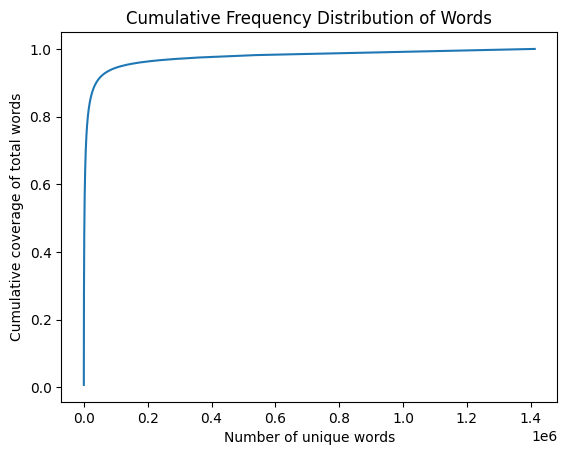

In [14]:
tk = Tokenizer()
tk.fit_on_texts(data['article'])

word_counts = tk.word_counts

sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

frequencies = np.array([count for word, count in sorted_word_counts])

cumulative_frequencies = np.cumsum(frequencies) / np.sum(frequencies)

plt.plot(cumulative_frequencies)
plt.xlabel('Number of unique words')
plt.ylabel('Cumulative coverage of total words')
plt.title('Cumulative Frequency Distribution of Words')
plt.show()

In [15]:
for i in [10000, 20000, 50000, 100000]:
    print(f"{i} words cover {cumulative_frequencies[i-1] * 100:.2f}% of the total text.")

10000 words cover 77.17% of the total text.
20000 words cover 84.87% of the total text.
50000 words cover 91.50% of the total text.
100000 words cover 94.42% of the total text.


In [16]:
print(f"{41000} words cover {cumulative_frequencies[41000-1] * 100:.2f}% of the total text.")

41000 words cover 90.37% of the total text.


In [17]:
max_vocab_size = 41000 

In [81]:
tk = Tokenizer(num_words=max_vocab_size)
tk.fit_on_texts(data['article'])
seq = tk.texts_to_sequences(data['article'])

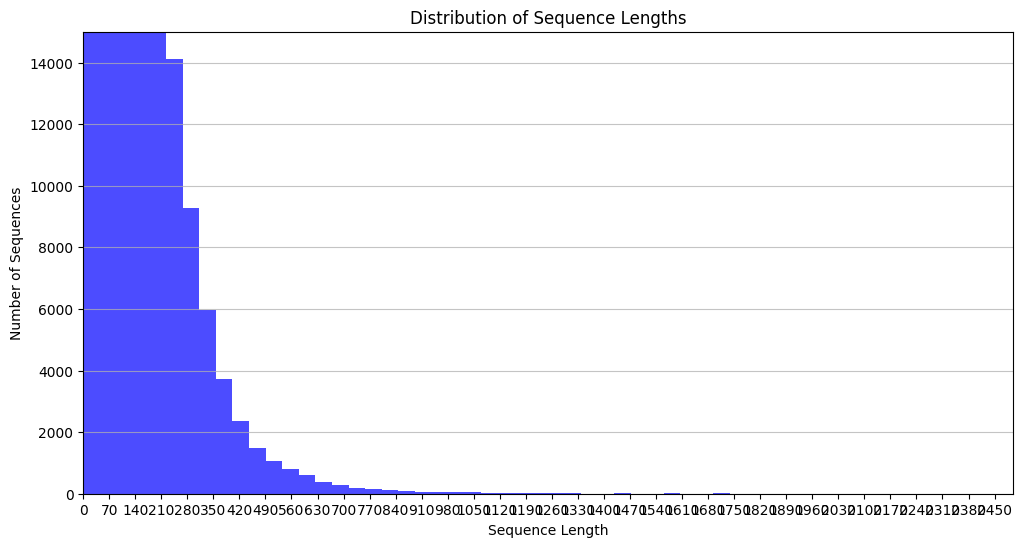

In [19]:

seq_lengths = [len(seq) for seq in seq]

# Plot the distribution of lengths
plt.figure(figsize=(12, 6))
plt.hist(seq_lengths, bins=100, color='blue', alpha=0.7)  


plt.xlim(0, 2500)  
plt.ylim(0, 15000)  

plt.xticks(np.arange(0, 2501, 70))  


plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [50]:
max_seq_length = 200

In [82]:
X = pad_sequences(seq, padding='post', maxlen=max_seq_length)  

# Labels are already label-encoded
y = data['class']  

# Dataset Splitting

In [83]:
# Split data: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Test data: {X_test.shape}, {y_test.shape}")

Training data: (260942, 200), (260942,)
Validation data: (32618, 200), (32618,)
Test data: (32618, 200), (32618,)


# Models

Model: "Bangla_News_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 200, 128)  │  5,273,600 │ Input_Layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 200, 128)  │          0 │ token_and_positi… │
│ (Attention)         │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 200, 128)  │          0 │ token_and_positi… │
│                     │                   │            │ attention_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 128)  │        512 │ layer_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 64)        │     41,216 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Layer       │ (None, 64)        │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer (Dense) │ (None, 32)        │      2,080 │ Dropout_Layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8)         │        264 │ Dense_Layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,317,928 (20.29 MB)

 Trainable params: 5,317,672 (20.29 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 169s 20ms/step - accuracy: 0.5492 - loss: 2.7022 - val_accuracy: 0.8931 - val_loss: 0.7550 - learning_rate: 1.0000e-04
Epoch 2/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.8843 - loss: 0.7901 - val_accuracy: 0.9042 - val_loss: 0.5670 - learning_rate: 1.0000e-04
Epoch 3/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.9096 - loss: 0.5947 - val_accuracy: 0.9118 - val_loss: 0.4994 - learning_rate: 1.0000e-04
Epoch 4/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.9225 - loss: 0.5123 - val_accuracy: 0.9120 - val_loss: 0.4764 - learning_rate: 1.0000e-04
Epoch 5/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.9324 - loss: 0.4653 - val_accuracy: 0.9141 - val_loss: 0.4651 - learning_rate: 1.0000e-04
Epoch 6/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 164s 20ms/step - accuracy: 0.9404 - loss: 0.4270 - val_accuracy: 0.9109 - val_loss: 0.4820 - learning_rate: 9.0484e-05
Epoch 7/20
8155/8155 ━━━━━━━━━━━━━

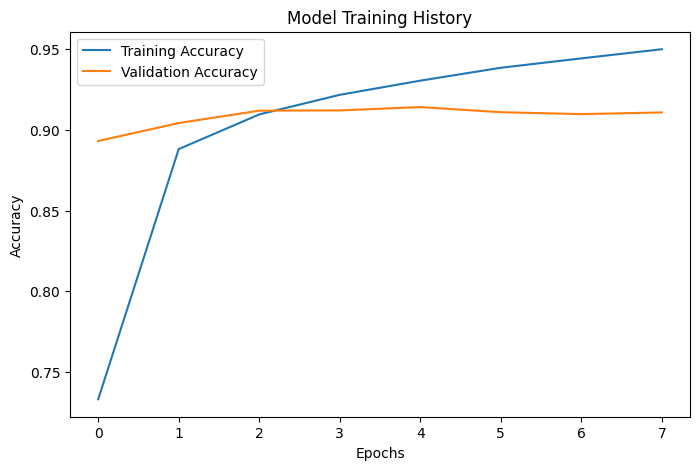

In [54]:

# Define the model
input_layer = Input(shape=(200,), name="Input_Layer")  

# Embedding layer with position embeddings 
embedding_layer = TokenAndPositionEmbedding(
    vocabulary_size=max_vocab_size,  
    sequence_length=max_seq_length,    
    embedding_dim=128       # Embedding dimension
)(input_layer)

#Attention Mechanism
attention_layer = Attention()([embedding_layer, embedding_layer])

#residual connection and Layer Normalization
attention_output = Add()([embedding_layer, attention_layer])  
attention_output = LayerNormalization()(attention_output)  

# BatchNormalization to stabilize the learning
attention_output = BatchNormalization()(attention_output)

# Bidirectional LSTM layer with L2 regularization
bidirectional_lstm = Bidirectional(LSTM(32, return_sequences=False, 
                                         kernel_regularizer=regularizers.l2(0.01),  
                                         name="BiLSTM_Layer"))(attention_output)

#Dropout for regularization 
dropout_layer = Dropout(0.8, name="Dropout_Layer")(bidirectional_lstm)

# Dense layer with L2 regularization
dense_layer = Dense(
    32, activation='relu', 
    kernel_regularizer=regularizers.l2(0.01),  
    name="Dense_Layer"
)(dropout_layer)

# Output layer for classification
output_layer = Dense(
    8, activation='softmax',#As there are 8 class
    kernel_regularizer=regularizers.l2(0.01),
    name="Output_Layer"
)(dense_layer)

# Define the final model
model1 = Model(inputs=input_layer, outputs=output_layer, name="Bangla_News_Classifier")

# Compile the model
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='sparse_categorical_crossentropy',  # As I label encoded (manually) 'y'not one-hot encoded
    metrics=['accuracy']
)

#here is the model summary
model1.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate scheduler to adjust the learning rate during training
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)  
    else:
        # Use TensorFlow's exp to decay the learning rate exponentially
        new_lr = lr * tf.math.exp(-0.1)  # Exponentially decay the learning rate
        return float(new_lr)  
lr_scheduler = LearningRateScheduler(scheduler)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


history = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=32,  
    callbacks=[early_stopping, lr_scheduler, reduce_lr]  
)

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training History')
plt.show()

In [55]:
model1.evaluate(X_test,y_test)

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9148 - loss: 0.4629


[0.4683172404766083, 0.9133607149124146]

In [56]:
y_pred1 = np.argmax(model1.predict(X_test), axis=1)

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


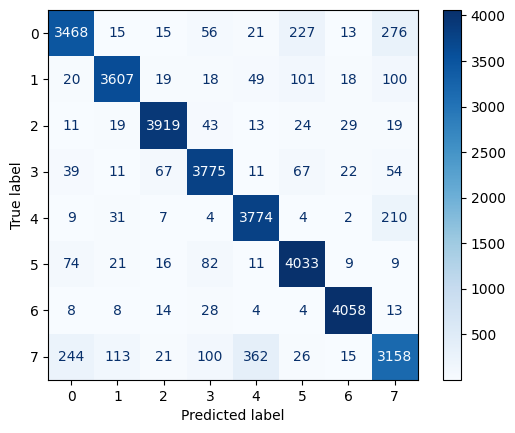

<Figure size 1000x800 with 0 Axes>

In [57]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cnf = confusion_matrix(y_test, y_pred1)
ConfusionMatrixDisplay(cnf).plot(cmap='Blues')
plt.figure(figsize=(10, 8))
plt.show()

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4091
           1       0.94      0.92      0.93      3932
           2       0.96      0.96      0.96      4077
           3       0.92      0.93      0.93      4046
           4       0.89      0.93      0.91      4041
           5       0.90      0.95      0.92      4255
           6       0.97      0.98      0.98      4137
           7       0.82      0.78      0.80      4039

    accuracy                           0.91     32618
   macro avg       0.91      0.91      0.91     32618
weighted avg       0.91      0.91      0.91     32618



In [59]:
model1.save('model3-1.h5')  
tf.saved_model.save(model1, 'exported_potrika_model3-1')  # let's also save in  SavedModel format

In [61]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tk, f)


In [64]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import tensorflow as tf

#unction for article classification
def classify_article(new_article, model_path='model3-1.h5', tokenizer_path='tokenizer.pkl', max_seq_length=200):
    # Load model
    model = load_model(model_path)

    # Load tokenizer
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)

    reverse_category_mapping = {v: k for k, v in category_mapping.items()}

    # Preprocess new article
    new_seq = tokenizer.texts_to_sequences([new_article])
    new_padded = pad_sequences(new_seq, maxlen=max_seq_length, padding='post')

    # Predict the class
    predictions = model.predict(new_padded)
    predicted_class_index = tf.argmax(predictions, axis=-1).numpy()[0]

    # Get the predicted class name
    predicted_class_name = reverse_category_mapping[predicted_class_index]

    return predicted_class_name

# Example usage:
new_article = """
বাংলাদেশে বর্তমানে রাজনৈতিক পরিস্থিতি উত্তপ্ত। সরকার বিরোধী দলগুলি সরকারের নানা সিদ্ধান্তের বিরুদ্ধে প্রতিবাদ জানাচ্ছে। 
বিশেষত, সম্প্রতি নির্বাচন কমিশনের ঘোষিত নতুন আইন এবং বাণিজ্যিক করের উপর সরকারের নতুন নীতি নিয়ে ব্যাপক আলোচনা চলছে। 
দেশের রাজনৈতিক অঙ্গনে এই পরিস্থিতি একটি গুরুত্বপূর্ণ মুহূর্ত হিসেবে চিহ্নিত হচ্ছে। দেশের উন্নয়ন ও সামগ্রিক অর্থনৈতিক পরিস্থিতি নিয়ে আলোচনা হতে থাকলেও রাজনৈতিক অস্থিরতা ভবিষ্যতে আরও বৃদ্ধি পেতে পারে।
"""

# Call the method
predicted_class = classify_article(new_article)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted class: Politics


In [65]:
new_article = """
ভারতের দাবা তারকা ডি. গুকেশ সম্প্রতি আন্তর্জাতিক দাবা প্রতিযোগিতায় একটি অসাধারণ বিজয় অর্জন করেছেন, যা দেশের দাবা প্রেমীদের মধ্যে আলোড়ন সৃষ্টি করেছে। গুকেশ, যিনি আন্তর্জাতিক দাবা মহলে তার অসামান্য দক্ষতা এবং বুদ্ধিমত্তার জন্য পরিচিত, তার এই বিজয় ভারতীয় দাবার নতুন দিগন্ত উন্মোচন করেছে।

ডি. গুকেশের এই সাফল্য শুধুমাত্র তার জন্য নয়, বরং ভারতীয় দাবা খেলার জন্যও একটি বড় অর্জন। গুকেশ তার সাম্প্রতিক প্রতিযোগিতায় বিশ্বের শীর্ষ দাবা খেলোয়াড়দের বিরুদ্ধে শক্তিশালী প্রতিদ্বন্দ্বিতা প্রদর্শন করেছেন এবং চমকপ্রদভাবে প্রতিটি প্রতিপক্ষকে পরাজিত করেছেন। তার এই বিজয়ে ভারতীয় দাবা দুনিয়ায় নতুন সম্ভাবনা সৃষ্টি হয়েছে এবং তার উদাহরণ দেখে তরুণ দাবা খেলোয়াড়রা অনুপ্রাণিত হচ্ছেন।

গুকেশের এই বিজয় বিশ্বমঞ্চে ভারতের গৌরব আরও বৃদ্ধি করেছে, এবং তার কঠোর পরিশ্রম, ধৈর্য এবং দক্ষতা সবার কাছে প্রশংসিত হয়েছে। তার পরবর্তী লক্ষ্য আরও বড় মঞ্চে ভারতের প্রতিনিধিত্ব করা এবং বিশ্ব দাবা খেলার শীর্ষে নিজেকে প্রতিষ্ঠিত করা।
"""

# Call the method
predicted_class = classify_article(new_article)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted class: Sports


In [69]:
new_article = """
ভারত একটি বহুত্ববাদী দেশ, যার সংস্কৃতি বিশ্বের অন্যতম প্রাচীন এবং বৈচিত্র্যময়। ভারতীয় সংস্কৃতি বিভিন্ন অঞ্চলের, ধর্ম, ভাষা, এবং ঐতিহ্যগুলির মিশ্রণ, যা দেশের প্রতিটি কোণে অনন্য এক রূপ ধারণ করেছে।

ভারতের সংস্কৃতির একটি অন্যতম দিক হল এর ঐতিহাসিক এবং ধর্মীয় উৎসব। প্রতিটি উৎসবের মধ্যে দেশের প্রাচীন ঐতিহ্য ও বিশ্বাস প্রতিফলিত হয়। যেমন, দিওয়ালি, হোলি, দুর্গাপূজা, এবং ঈদ-এ-আল-ফিতর, এসব উৎসব ভারতের মানুষের জীবনযাত্রার অঙ্গ হয়ে উঠেছে।

এছাড়াও, ভারতের সঙ্গীত, নৃত্য, এবং শিল্পকলা বিশ্বব্যাপী পরিচিত। ভারতীয় classical সঙ্গীতের নানা রূপ যেমন হিন্দুস্তানি, carnatic, এবং বিভিন্ন লোক সঙ্গীত শৈলী দেশের সাংস্কৃতিক ঐতিহ্যের অমূল্য রত্ন। ভারতীয় নৃত্যশিল্প যেমন ভারতনাট্যম, kathak, ও kathakali আন্তর্জাতিক স্তরে ব্যাপক পরিচিত।

ভারতীয় সাহিত্যও বিশ্ব সাহিত্যের এক গুরুত্বপূর্ণ অংশ। ভারতে অজস্র মহাকাব্য, উপন্যাস, এবং কবিতা রচিত হয়েছে, যা সংস্কৃতি এবং জীবনের নানা দিককে তুলে ধরে। রবীন্দ্রনাথ ঠাকুর, মধুসূদন দত্ত, এবং হুমায়ূন আহমেদ- এই সব লেখক তাদের সাহিত্যকর্মের মাধ্যমে বিশ্বের নানা প্রান্তে ভারতীয় সংস্কৃতির সঙ্গীত শোনিয়েছেন।

বর্তমান সময়ে, ভারতীয় সংস্কৃতি আধুনিকতা এবং প্রচলিত ঐতিহ্যের মেলবন্ধন ঘটিয়ে চলেছে। ডিজিটাল মিডিয়া, চলচ্চিত্র, এবং টেলিভিশন অনুষ্ঠানগুলোর মাধ্যমে ভারতীয় সংস্কৃতি আজ বিশ্বব্যাপী পরিচিত এবং জনপ্রিয়।"""

# Call the method
predicted_class = classify_article(new_article)
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Predicted class: Entertainment


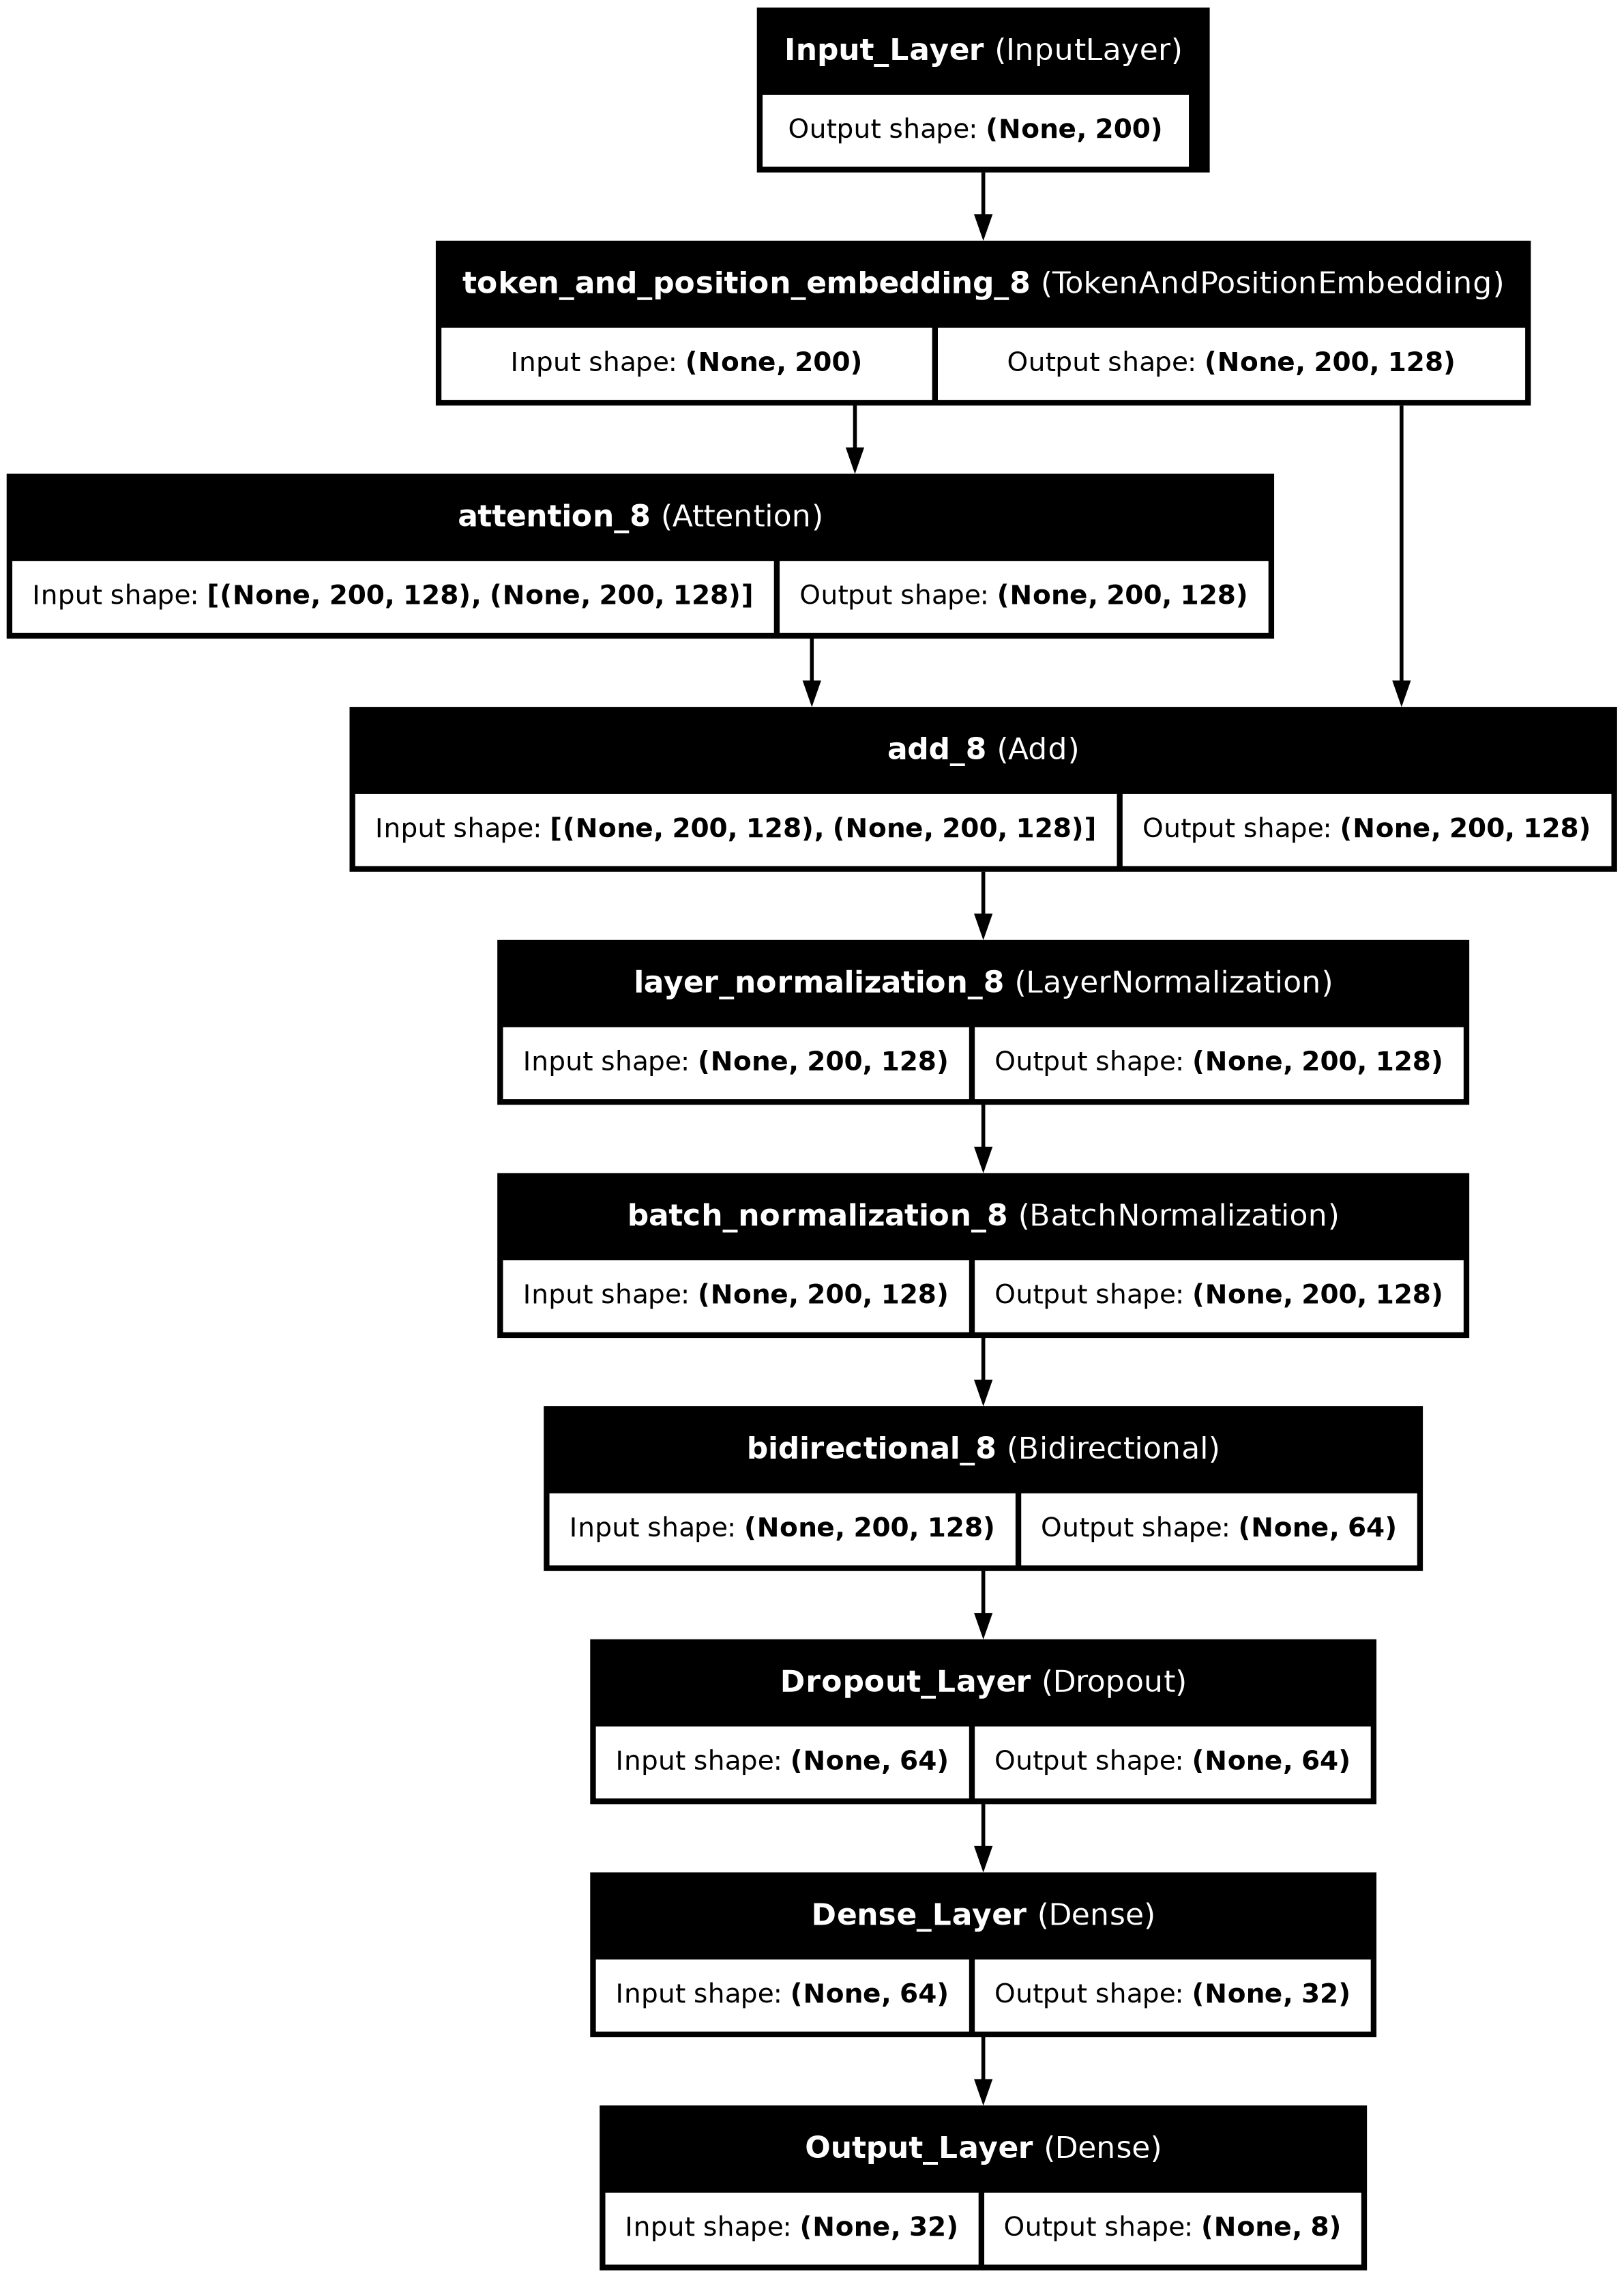

In [91]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model1, to_file='/kaggle/working/model_architecture_1.png', show_shapes=True, show_layer_names=True)

# Display the image of the model
from IPython.display import Image
Image(filename='/kaggle/working/model_architecture_1.png')


Model: "Bangla_News_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 200, 256)  │ 10,547,200 │ Input_Layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_20        │ (None, 200, 256)  │          1 │ token_and_positi… │
│ (Attention)         │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 200, 256)  │          0 │ token_and_positi… │
│                     │                   │            │ attention_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 256)  │        512 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 256)  │      1,024 │ layer_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 128)       │    164,352 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Layer       │ (None, 128)       │          0 │ bidirectional_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Layer (Dense) │ (None, 64)        │      8,256 │ Dropout_Layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8)         │        520 │ Dense_Layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,721,865 (40.90 MB)

 Trainable params: 10,721,353 (40.90 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 227s 28ms/step - accuracy: 0.6475 - loss: 3.3152 - val_accuracy: 0.9062 - val_loss: 0.6605 - learning_rate: 1.0000e-04
Epoch 2/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 224s 27ms/step - accuracy: 0.9129 - loss: 0.6254 - val_accuracy: 0.9129 - val_loss: 0.4733 - learning_rate: 1.0000e-04
Epoch 3/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 224s 27ms/step - accuracy: 0.9296 - loss: 0.4532 - val_accuracy: 0.9133 - val_loss: 0.4629 - learning_rate: 1.0000e-04
Epoch 4/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 223s 27ms/step - accuracy: 0.9380 - loss: 0.4134 - val_accuracy: 0.9159 - val_loss: 0.4320 - learning_rate: 1.0000e-04
Epoch 5/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 224s 27ms/step - accuracy: 0.9438 - loss: 0.3777 - val_accuracy: 0.9134 - val_loss: 0.4432 - learning_rate: 1.0000e-04
Epoch 6/20
8155/8155 ━━━━━━━━━━━━━━━━━━━━ 224s 27ms/step - accuracy: 0.9521 - loss: 0.3422 - val_accuracy: 0.9135 - val_loss: 0.4463 - learning_rate: 8.1873e-05
Epoch 7/20
8155/8155 ━━━━━━━━━━━━━

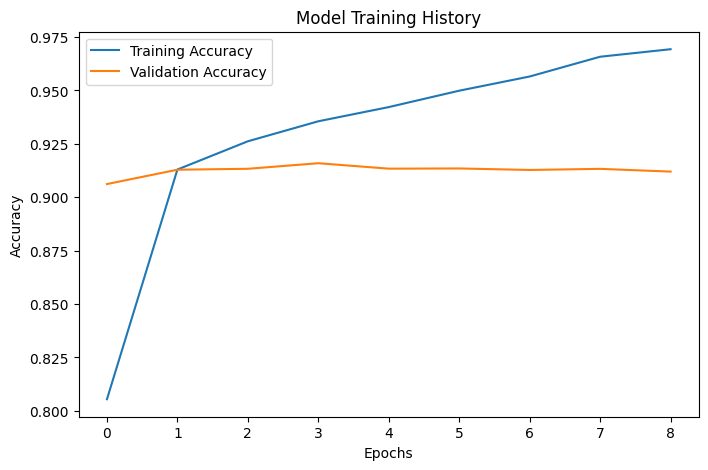

1020/1020 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9160 - loss: 0.4301
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


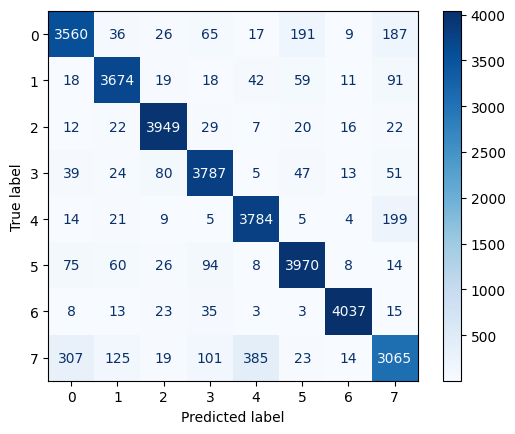

<Figure size 1000x800 with 0 Axes>

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4091
           1       0.92      0.93      0.93      3932
           2       0.95      0.97      0.96      4077
           3       0.92      0.94      0.93      4046
           4       0.89      0.94      0.91      4041
           5       0.92      0.93      0.93      4255
           6       0.98      0.98      0.98      4137
           7       0.84      0.76      0.80      4039

    accuracy                           0.91     32618
   macro avg       0.91      0.91      0.91     32618
weighted avg       0.91      0.91      0.91     32618



In [90]:
from tensorflow.keras.layers import Input,Attention, Add, LayerNormalization, BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the model
input_layer = Input(shape=(200,), name="Input_Layer")

# Embedding layer with position embeddings
embedding_layer = TokenAndPositionEmbedding(
    vocabulary_size=max_vocab_size,
    sequence_length=max_seq_length,
    embedding_dim=256  
)(input_layer)

# Attention Mechanism (scaled dot-product attention)
attention_layer = Attention(use_scale=True)([embedding_layer, embedding_layer])

attention_output = Add()([embedding_layer, attention_layer])
attention_output = LayerNormalization()(attention_output)

attention_output = BatchNormalization()(attention_output)

bidirectional_lstm = Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01), name="BiLSTM_Layer")
)(attention_output)

dropout_layer = Dropout(0.8, name="Dropout_Layer")(bidirectional_lstm)

# Dense layer with L2 regularization
dense_layer = Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(0.01),
    name="Dense_Layer"
)(dropout_layer)

output_layer = Dense(
    8, activation='softmax',  # 8 classes
    kernel_regularizer=regularizers.l2(0.01),
    name="Output_Layer"
)(dense_layer)

model2 = Model(inputs=input_layer, outputs=output_layer, name="Bangla_News_Classifier")

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

model2.summary()

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)  
    else:
        # Use TensorFlow's exp to decay the learning rate exponentially
        new_lr = lr * tf.math.exp(-0.2)  # Exponentially decay the learning rate
        return float(new_lr) 

lr_scheduler = LearningRateScheduler(scheduler)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler, reduce_lr]
)

# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training History')
plt.show()


model2.evaluate(X_test,y_test)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)

cnf = confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(cnf).plot(cmap='Blues')
plt.figure(figsize=(10, 8))
plt.show()

print(classification_report(y_test, y_pred2))

In [97]:
model2.save('model3-2.h5')  
tf.saved_model.save(model2, 'exported_potrika_model3-2')  # let's also save in  SavedModel format

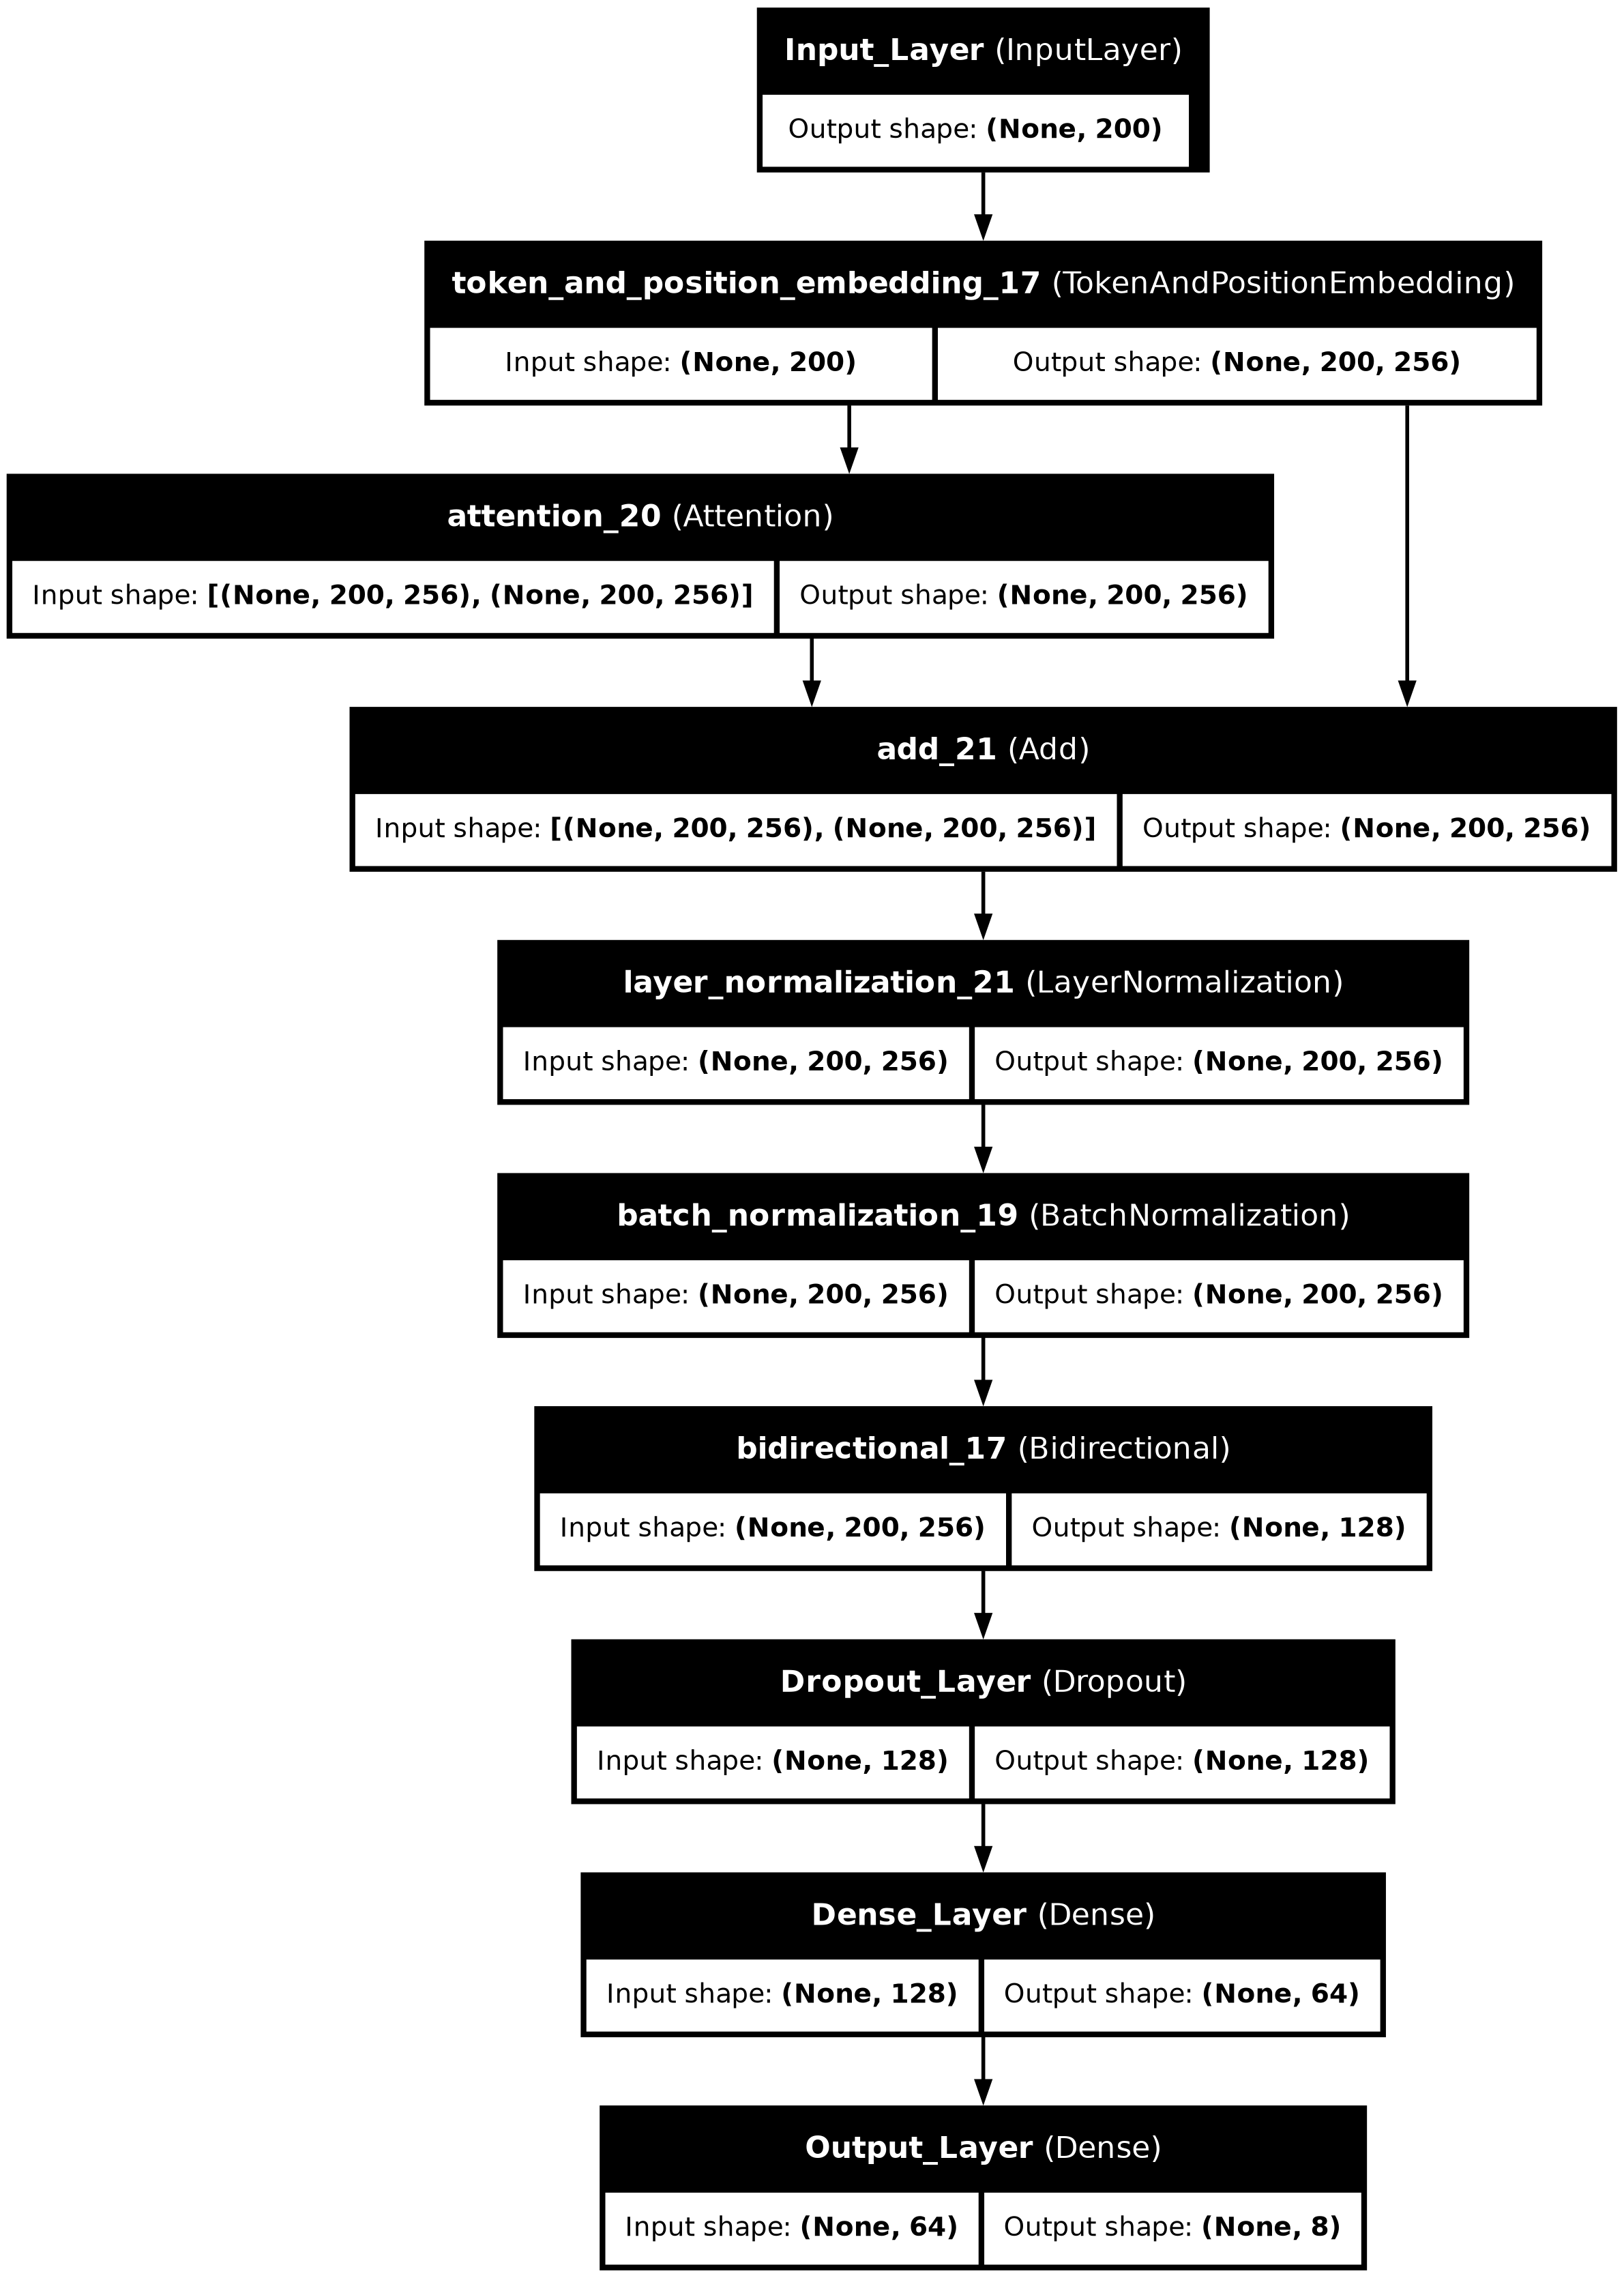

In [92]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model2, to_file='/kaggle/working/model_architecture_2.png', show_shapes=True, show_layer_names=True)

# Display the image of the model
from IPython.display import Image
Image(filename='/kaggle/working/model_architecture_2.png')
